<a href="https://www.kaggle.com/mishki/resnet-keras-code-from-scratch-train-on-gpu?scriptVersionId=86254640" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# <center>Coding a customized ResNet50 in Keras

In this notebook I'll code a <strong>50-layer ResNet</strong> model from scrath using Keras.<br/><br/>
ResNets were introduced by <a href="https://openaccess.thecvf.com/content_cvpr_2016/papers/He_Deep_Residual_Learning_CVPR_2016_paper.pdf">He et al. 2016</a> to bypass the problem or <a href="https://www.youtube.com/watch?v=qhXZsFVxGKo">vanishing and exploding gradients in very deep neural networks</a>. 
<br/><br/>
I want to implement this model myself instead of using an existing library because this will give me a deeper understanding of ResNet and because it's a nice ooportunity to get familiar with <a href="https://keras.io/">Keras</a>.
<br/><br/> 
For this project I'll use the <a href="https://www.kaggle.com/alessiocorrado99/animals10">10 Animals dataset available on Kaggle</a>. 
<br/><br/> 
If you want to jump right to using a ResNet, have a look at <a href='https://keras.io/api/applications/'>Keras' pre-trained models</a>. In this Notebook I will code my ResNet from scratch not out of need, as implementations already exist, but as a valuable learning process.
<br/><br/>
To see the duration of training on a Kaggle CPU, don't activate the GPU accelerator for this Notebook until you reach section 6. When I publish this Notebook, I can either have the GPU activated from the start for the whole Notebook or not at all, I can't have half-half, for demo purposes.
<br/><br/>
So, in order to observe the snail speed of section 5, you should manually deactivate GPU and reactivate once you reach section 6 (at which point, you'll have to re-run everything, but will be fast from then on).  

## Table of contents

1. [Setting up our environment](#1.-Setting-up-our-environment)
2. [What are ResNets and how they work](#2.-What-are-ResNets-and-how-they-work)
3. [ResNet building blocks](#3.-The-building-blocks)
4. [Defining the ResNet model](#4.-Defining-the-ResNet-model)
5. [Training the ResNet model](#5.-Training-the-ResNet-model)
6. [Training the ResNet model on Kaggle GPU](#6.-Training-the-ResNet-model-on-Kaggle-GPU)
7. [Making predictions](#7.-Making-predictions)
8. [Overfitting when training our Residual Neural Network](#8.-Overfitting-when-training-our-Residual-Neural-Network)
9. [Wrapping up](#9.-Wrapping-up)

# 1. Setting up our environment

Keras is a high level API on top of TensorFlow. More information, as well as documentation, is available <a href="https://www.tensorflow.org/api_docs/python/tf/keras">here, on TensorFlow.org</a>. But probably a better introduction is the one on <a href="https://keras.io/about/">Keras' website</a>.

It used to be the case that Keras was a high level API that you could configure to use one of three possible underlying Neural Networks API:  
- TensorFlow
- Theano
- CNTK

Later, Keras became integrated with TensorFlow and it comes bundled in latest versions of it. So I no longer have to install it as a separate library, like it was the case in the past. 

Therefore, in order to install Keras, I need to get TensorFlow.

If you don't have Tensorflow installed and if you're using Anaconda, like me (I created this notebook in my local Jupyter Notebook), check <a href="https://anaconda.org/search?q=tensorflow">Anaconda official website</a> to see which version is available for installation through Anaconda. 

At the moment, the latest available through Anaconda is 2.3.0

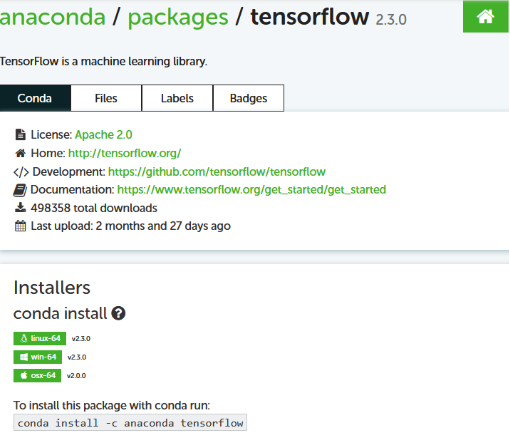

But I want the global latest, which is 2.4. So I used pip to install it. 

In [1]:
#!pip install --ignore-installed --upgrade tensorflow==2.4.1 --user

Let's import the necessary libraries for this project.  

In [2]:
import time
import numpy as np
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.preprocessing import image
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D

from tensorflow.python.keras.utils import layer_utils
#from tensorflow.keras.utils.vis_utils import model_to_dot
from tensorflow.keras.utils import model_to_dot
from tensorflow.keras.utils import plot_model

from tensorflow.keras.models import Model, load_model
from tensorflow.keras.applications.imagenet_utils import preprocess_input

from tensorflow.keras.initializers import glorot_uniform

import pydot

from IPython.display import SVG

#from resnets_utils import *
import scipy.misc
from matplotlib.pyplot import imshow

%matplotlib inline

import tensorflow.keras.backend as K
K.set_image_data_format('channels_last') # can be channels_first or channels_last. 
K.set_learning_phase(1) # 1 stands for learning phase

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/backend.py:434: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn('`tf.keras.backend.set_learning_phase` is deprecated and '


# 2. What are ResNets and how they work

Currently, there is a trend in Machine Learning, especially in computer vision and speech recognition, to use deeper and deeper neural networks. The reason behind this is the current consensus that deeper networks can learn more complex problems. 

Deep Neural Networks suffer from one pervasive problem: <a href="https://www.youtube.com/watch?v=qhXZsFVxGKo">vanishing gradients </a>. There's also the less common problem of <a href="https://www.youtube.com/watch?v=qhXZsFVxGKo">exploding gradients.</a>

Vanishing gradients make the network learn very slow or may completely stop it from continuing to learn. Why ? The network learns (improves its weights and biases) through backpropagation. During backpropagation*, I computes the partial derivative of the cost function with respect to each weight and bias in each layer, progressively going from the final layers towards the front layers. 

In a very deep network, as we progress from last layers towards the first layers and computing partial derivatives, these values become smaller and smaller. Which means we will do near zero modifications to weights and biases in front layers. This basically means those layers are hardly doing any learning.  

While working on very deep computer vision networks, <a href="https://openaccess.thecvf.com/content_cvpr_2016/papers/He_Deep_Residual_Learning_CVPR_2016_paper.pdf">He et al. 2016</a> found a way to bypass the vanishing gradients problem.  

It doesn't sound so intuitive to me how He's approach solves this problem, but it works. Their solution is to take the output of one layer and to jump over a few layers and input this deeper into the neural network. Here is how the authors illustrate this mechanism in their <a href="https://openaccess.thecvf.com/content_cvpr_2016/papers/He_Deep_Residual_Learning_CVPR_2016_paper.pdf">article.</a>

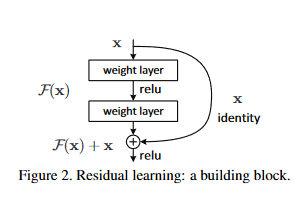
Reproduced from <a href="https://openaccess.thecvf.com/content_cvpr_2016/papers/He_Deep_Residual_Learning_CVPR_2016_paper.pdf">He et al 2016.</a>

The building block above is called a residual block or the identity block. The "weight layer" is a typical convolutional layer** , the classical type for image recognition networks. Normally, we would have a convolutional layer, then a non-linearity (here, the ReLU function), a convolutional layer, a ReLU and so on.  

ResNets introduce a **direct connection** (a bypass) that jumps over two convolutional layers and the ReLU in between (it can be more than two though). This way the second ReLU in this picture will have as input, instead of F(x) (like a typical CNN), an F(x) + x.

It was found empirically that a ResNet did not behave like a traditional very deep NN. Can be seen in the image below, from the same article - better than expressed through words.

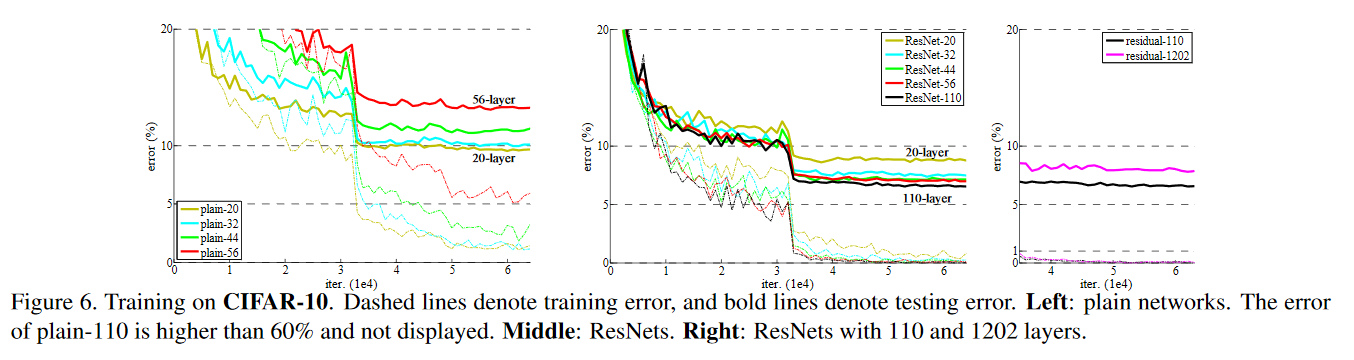

\* For an in-depth description of the backpropagation mechanism and also to understand the Mathematics behind it, I recommend <a href="http://neuralnetworksanddeeplearning.com/chap2.html">Chapter 2 from Michael Nielsen's free book on Neural Networks and Deep Learning: Introduction to the core principles</a>. I found this to be the best resource on this topic.  

** For an intro to Convolutional Neural Networks, see this overview from the freely available <a href="https://cs231n.github.io/convolutional-networks/">CS231n: Convolutional Neural Networks for Visual Recognition</a> from Stanford. 

# 3. ResNet building blocks

In the previous section I talked about the **identity block**. The one above skipped over two convolution layers. A more powerful version of the residual block is one that skips over three convolutional layers. In this notebook I will implement the latter.

I will also use a batch normalization layer after each convolutional layer, which helps by speeding up the training. If you want to read more about this, check out this article on <a href="https://machinelearningmastery.com/batch-normalization-for-training-of-deep-neural-networks/">Machine Learning Mastery</a>.

The **identity block** is used when the input x has the same dimension (width and height) as the output of the third layer. 
When this condition is not met, we use a **convolution block**. 

The only difference between the identity block and the convolution block is that the second has another convolution layer (plus a batch normalization) on the skip conection path. The convolution layer on the skip connection path has the purpose of resizing x so that its dimension matches the output and thus we would be able to add those two together.

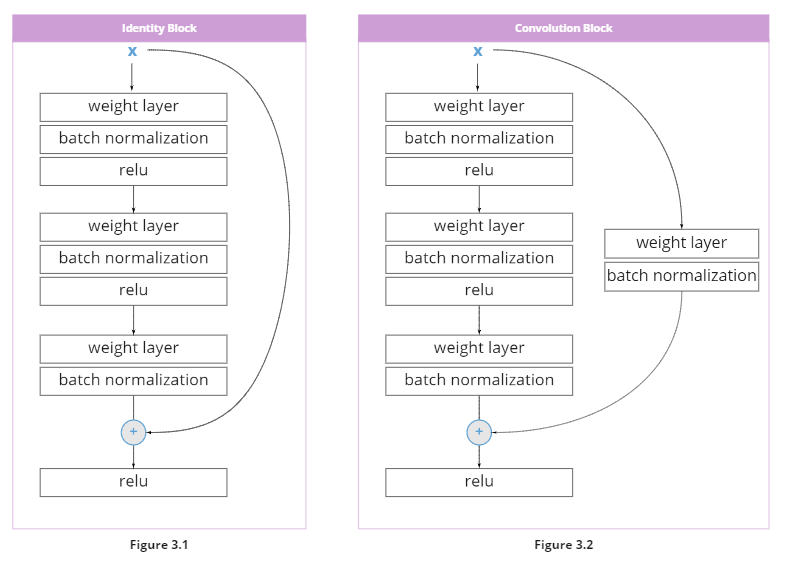

I will use 3x3 and 1x1 convolutional layers, like in the original ResNet article.

In [3]:
def identity_block(X, level, block_no, filters):
    """
    Identity block as seen in figure 3.1
    
    Inputs:
    X - input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    level - integer, one of the 5 levels that our networks is conceptually divided into (see figure 3.1 in next section)
    block_no - each level has multiple layers block_no will be n for the 'n'th layer in current block
    filters - a list on integers, each of them defining the number of filters in each convolutional layer 
    
    
    Output:
    X - tensor (m, n_H, n_W, n_C)
    """
    
    """
    layers will be called {block_name}_1, {block_name}_2 and {block_name}_3 
    eg: the 2nd convolutional layer in the 5th identity block in level 4 will be called 
    conv4_iden_5_2
    """
    conv_base_name = 'conv' + str(level) + 'iden' + str(block_no)
    norm_name = 'norm' + str(level) + 'iden' + str(block_no)
    
    f1, f2, f3 = filters
    
    # we will need this for the shortcut path
    X_shortcut = X
    
    # first convolutional layer
    X = Conv2D(filters = f1, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_base_name + '1', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = norm_name + '1')(X)
    X = Activation('relu')(X)
    
    # second convolutional layer
    X = Conv2D(filters = f2, kernel_size = (3, 3), strides = (1,1), padding = 'same', name = conv_base_name + '2', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = norm_name + '2')(X)
    X = Activation('relu')(X)    

    # third convolutional layer
    X = Conv2D(filters = f3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_base_name + '3', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = norm_name + '3')(X)
    
    # shortcut
    X = Add()([X, X_shortcut])
    
    # nonlinearity
    X = Activation('relu')(X)
    
    return X

In [4]:
def convolutional_block(X, level, block_no, filters, s = (2,2)):
    """
    Convolutional block as seen in figure 3.1
    
    Inputs:
    X - input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    block_no - each level has multiple layers; block_no will be n for the 'n'th layer in current block
    filters - a list on integers, each of them defining the number of filters in each convolutional layer 
    level - integer, one of the 5 levels that our networks is conceptually divided into (see figure 3.1 in next section)
    s - stride of the first layer; remember that the convolutional layer is used to change the dimension of X; an s=2 will reduce the width and height to half.
    
    Output:
    X - tensor (n_H, n_W, n_C)
    """
    
    """
    layers will be called {block_name}_1, {block_name}_2 and {block_name}_3 
    eg: the 2nd convolutional layer in the 5th identity block in level 4 will be called 
    conv4_iden_5_2
    """
    conv_base_name = 'conv' + str(level) + 'conv' + str(block_no)
    norm_name = 'conv' + str(level) + 'norm' + str(block_no)
    
    f1, f2, f3 = filters
    
    # we will need this for the shortcut path
    X_shortcut = X
    
    # first convolutional layer
    X = Conv2D(filters = f1, kernel_size = (1, 1), strides = s, padding = 'valid', name = conv_base_name + '1', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = norm_name + '1')(X)
    X = Activation('relu')(X)
    
    # second convolutional layer
    X = Conv2D(filters = f2, kernel_size = (3, 3), strides = (1,1), padding = 'same', name = conv_base_name + '2', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = norm_name + '2')(X)
    X = Activation('relu')(X)    

    # third convolutional layer
    X = Conv2D(filters = f3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_base_name + '3', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = norm_name + '3')(X)
    
    # shortcut path
    X_shortcut = Conv2D(filters = f3, kernel_size = (1, 1), strides = s, padding = 'valid', name = conv_base_name + 'short', kernel_initializer = glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3, name = norm_name + 'short')(X_shortcut)
    
    # shortcut
    X = Add()([X, X_shortcut])
    
    # nonlinearity
    X = Activation('relu')(X)
    
    return X

# 4. Defining the ResNet model

Here is what my 50 layers ResNet will look like:

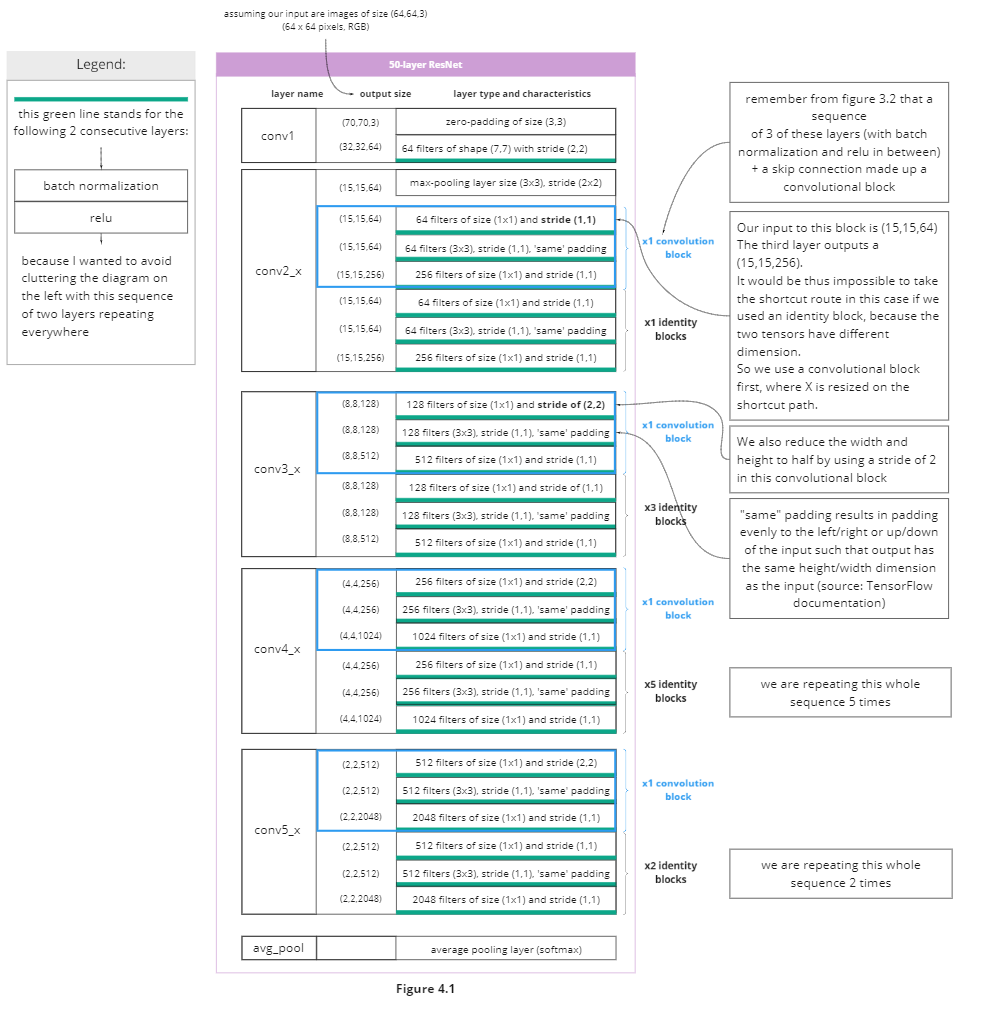

I will just hardcode the image and filter dimensions to make it easier to read. In a real developing environment, most values below should look like INPUT_WIDTH, 2 * INPUT_WIDTH and so on.

In [5]:
def ResNet50L(input_size, classes):
    
    """
    Implementation of the 50-layer ResNet model according to figure 4.1 above
    
    Inputs:
    input_size - a (n_H, n_W, n_C) touple, the shape of our input images
    classes - integer, number of classes

    Returns:
    model - a Keras Model() instance
    """
    
    # Define a tensor placesholder for our input
    X_input = Input(input_size)

    ### Level 1 ###
    # padding
    X = ZeroPadding2D((3, 3))(X_input)
    # convolutional layer, followed by batch normalization and relu activation
    X = Conv2D(filters = 64, kernel_size = (7, 7), strides = (2, 2), name = 'conv1', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = 'bn_conv1')(X)
    X = Activation('relu')(X)
    
    ### Level 2 ###
    # a max pooling layer
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)
    # 1x convolutional block
    X = convolutional_block(X, level = 2, block_no = 1, filters = [64,64,256], s=(1,1))
    # 2x identity blocks 
    X = identity_block(X, level = 2, block_no = 1, filters = [64,64,256])
    X = identity_block(X, 2, 2, [64,64,256])
    
    ### Level 3 ###
    # 1x convolutional block
    X = convolutional_block(X, level = 3, block_no = 1, filters = [128,128,512], s=(2,2))
    # 3x identity blocks 
    X = identity_block(X, 3, 2, [128,128,512])
    X = identity_block(X, 3, 3, [128,128,512])
    X = identity_block(X, 3, 4, [128,128,512])
    
    ### Level 4 ###
    # 1x convolutional block
    X = convolutional_block(X, level = 4, block_no = 1, filters = [256,256,1024], s=(2,2))
    # 5x identity blocks 
    X = identity_block(X, 4, 2, [256,256,1024])
    X = identity_block(X, 4, 3, [256,256,1024])
    X = identity_block(X, 4, 4, [256,256,1024])
    X = identity_block(X, 4, 5, [256,256,1024])
    X = identity_block(X, 4, 6, [256,256,1024])
    
    ### Level 5 ###
    # 1x convolutional block
    X = convolutional_block(X, level = 5, block_no = 1, filters = [512,512,2048], s=(2,2))
    # 2x identity blocks 
    X = identity_block(X, 5, 2, [512,512,2048])
    X = identity_block(X, 5, 3, [512,512,2048])
    
    # Pooling layers
    X = AveragePooling2D(pool_size=(2, 2), name='avg_pool')(X)
    
    # Output layer
    X = Flatten()(X)
    X = Dense(classes, activation='softmax', name='fully_connected_' + str(classes), kernel_initializer = glorot_uniform(seed=0))(X)
    
    
    # Create model
    model = Model(inputs = X_input, outputs = X, name='ResNet50L')

    return model

If you're a beginner with TensorFlow, like me, you might find this <a href="https://www.tensorflow.org/guide/intro_to_graphs">introduction to TensorFLow graphs</a> useful. The alternative to graphs is running the model in eager mode, which you can read a little bit about <a href="https://www.tensorflow.org/guide/eager">here</a>.

Let's instantiate the model.  

In [6]:
model = ResNet50L(input_size = (64, 64, 3), classes = 10)

Let's examine the structure of our model by running the following code:

In [7]:
model.summary()

Model: "ResNet50L"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 70, 70, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 32, 32, 64)   9472        zero_padding2d[0][0]             
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 32, 32, 64)   256         conv1[0][0]                      
__________________________________________________________________________________________

# 5. Training the ResNet model

Now that we defined our model, it's time to train it.  

### 5.1 Loading and preparing the image dataset.

Have a look at the contents of the data folder and see ohw many images we have.

In [8]:
import os

cwd = os.getcwd()
print(cwd)

file_count = []
data_folder = '../input/animals10/raw-img' 

for fld in os.listdir(data_folder+'/'):
    image_count = len(os.listdir(data_folder+'/'+fld))
    file_count.append(image_count)
    
    print(f'{data_folder}/{fld} contains {image_count} images')
    

/kaggle/working
../input/animals10/raw-img/cavallo contains 2623 images
../input/animals10/raw-img/pecora contains 1820 images
../input/animals10/raw-img/elefante contains 1446 images
../input/animals10/raw-img/gatto contains 1668 images
../input/animals10/raw-img/scoiattolo contains 1862 images
../input/animals10/raw-img/gallina contains 3098 images
../input/animals10/raw-img/ragno contains 4821 images
../input/animals10/raw-img/mucca contains 1866 images
../input/animals10/raw-img/cane contains 4863 images
../input/animals10/raw-img/farfalla contains 2112 images


In [9]:
print(f'Total number of images: {sum(file_count)}')

Total number of images: 26179


Let's inspect the contents of an image folder.  

In [10]:
os.listdir(data_folder+'/elefante')[:10]

['OIP-QeF6RwJQuXjYWQOXa4PLGwHaE6.jpeg',
 'OIP-GIzroxEWulvjZ6Me9KFSnwHaFj.jpeg',
 'OIP--UnQR8C6k6T8rQuJOQ87QgHaFj.jpeg',
 'eb3cb80d2ff2023ed1584d05fb1d4e9fe777ead218ac104497f5c978a4efbcb0_640.jpg',
 'OIP-Lbhfmoj1wIbVE55UJcTWhAHaFm.jpeg',
 'OIP-rrkOpZ0fsGh_zA9Bz7bTOQHaE8.jpeg',
 'OIP-JI-VgUkErsyomorkv0tFFgHaFU.jpeg',
 'eb32b50829f4043ed1584d05fb1d4e9fe777ead218ac104497f5c978a4efbcb0_640.jpg',
 'ef3db60c2bfc1c22d2524518b7444f92e37fe5d404b0144390f8c07aa5ecb6_640.jpg',
 'OIP-qTwcqBDv0BLl_DNQamz99wHaDt.jpeg']

So, each directory contains images of one type of animal, as the folder name itself suggested.  

I just wanna check out a couple of samples.

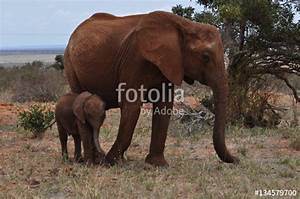

In [11]:
import PIL
import PIL.Image

import pathlib
data_dir = pathlib.Path(data_folder)

elefante = list(data_dir.glob('elefante/*'))
PIL.Image.open(str(elefante[0]))

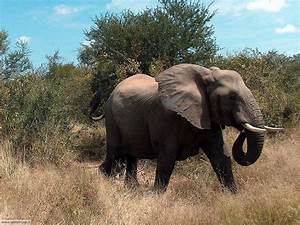

In [12]:
PIL.Image.open(str(elefante[10]))

First thing I notice: the images are not squared. When I defined the network, I set the input to 64x64 RGB images.   

So, for this particular dataset, I'll just crop the images to make them square before resizing to 64x64. I can also resize directly, in which case the images would look vertically stretched. But since the target object looks almost centered, I think I can get away with cropping. 

Let's first check the current width and height.

In [13]:
im = PIL.Image.open(str(elefante[10]))
width, height = im.size
print(f'{width} x {height}')

300 x 225


In [14]:
cane = list(data_dir.glob('cane/*'))
im = PIL.Image.open(str(cane[20]))
width, height = im.size
print(f'{width} x {height}')

300 x 169


Our images have different sizes too.

Let's crop our images to a square the size of their respective height. 

At the same time, I'll delete the extra images. I want to have equal amounts of data for all target classes.  

Earlier we made a list of number of images we have for each class. We will keep min(file_count) files in each animal category and delete the rest.

In [15]:
def square_crop_image(folder, file_name, k, out):
    with PIL.Image.open(folder + '/' + file_name) as im:
        width, height = im.size 
        new_size = min(width, height) 

        # center crop
        left = (width - new_size)/2
        top = (height - new_size)/2
        right = (width + new_size)/2
        bottom = (height + new_size)/2

        crop_im = im.crop((left, top, right, bottom)) 
        crop_im = crop_im.convert('RGB')
        crop_im.save(out + '/' + str(k) + ".jpg")  
        im.close()  

data_folder = '../input/animals10/raw-img'
out_folder = '../output/animals10/processed'

if not os.path.exists(out_folder):
    os.makedirs(out_folder)

for fld in os.listdir(data_folder+'/'):
    k = 1
    
    if not os.path.exists(out_folder + '/' + fld):
        os.makedirs(out_folder + '/' + fld)
    
    for file in os.listdir(data_folder+'/' + fld):
        square_crop_image(data_folder + '/'+ fld, file, k, out_folder + '/' + fld)
        k = k+1
        if (k > min(file_count)):
            break

Now we use Keras preprocessing utilities to prepare our dataset. The method I am using below for loading images from separate folders is described in <a href='https://www.tensorflow.org/tutorials/load_data/images'>TensforFlow official documentation here</a>.

In [16]:
!ls ../output/animals10/processed

cane	 elefante  gallina  mucca   ragno
cavallo  farfalla  gatto    pecora  scoiattolo


In [17]:
img_height = 64
img_width = 64
batch_size = 32

In [18]:
data_dir = pathlib.Path(out_folder)

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split = 0.2,
    subset="training",
    #batch_size = 10 * min(file_count),
    label_mode='categorical', # default mode is 'int' label, but we want one-hot encoded labels (e.g. for categorical_crossentropy loss)
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    label_mode='categorical',
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 14460 files belonging to 10 classes.
Using 11568 files for training.
Found 14460 files belonging to 10 classes.
Using 2892 files for validation.


In [19]:
class_names = train_ds.class_names
print(class_names)

['cane', 'cavallo', 'elefante', 'farfalla', 'gallina', 'gatto', 'mucca', 'pecora', 'ragno', 'scoiattolo']


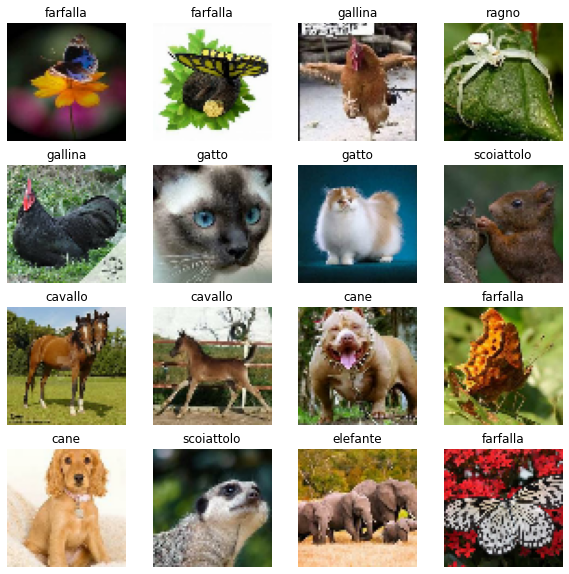

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))

i = 1

for images, labels in train_ds.take(1):
    for (image, label) in zip(images, labels): 
        ax = plt.subplot(4, 4, i)
        plt.imshow(image.numpy().astype("uint8"))
        plt.title(class_names[tf.argmax(label, axis=0)])
        plt.axis("off")
        i = i + 1
        if i == 17:
            break
plt.show()

Cropping was not the best solution, but I'll work with that now.

Let's convert to numpy arrays for feeding them to our model later.  
 
We convert our labels (e.g. right now we have a label of 1 which stands for the class 'cavallo' for example) through one-hot-encoding (our label of 1 from my example thus becomes the array: 0 1 0 0 0 0 0 0 0 0).  

You can read about how one-hot encoding is implemented in TensorFlow <a href='https://www.tensorflow.org/api_docs/python/tf/one_hot'>here</a>.  

For a discussion on why one hot encoding is preferred, check out section 4 in <a href='https://machinelearningmastery.com/how-to-prepare-categorical-data-for-deep-learning-in-python/'>this tutorial</a>.

In [21]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

In [22]:
norm_train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
norm_val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))

image_batch, labels_batch = next(iter(norm_train_ds))
first_image = image_batch[0]

# pixel values are now in the [0,1] range
print(np.min(first_image), np.max(first_image))

0.0 1.0


### 5.2 Model training

First, choose an optimizer schedule, a loss function and metrics to track during training.

In [23]:
model.compile(
    optimizer='adam', # optimizer
    loss='categorical_crossentropy', # loss function to optimize 
    metrics=['accuracy'] # metrics to monitor
)

Configure the dataset for performance

In [24]:
AUTOTUNE = tf.data.AUTOTUNE

norm_train_ds = norm_train_ds.cache().prefetch(buffer_size=AUTOTUNE)
norm_val_ds = norm_val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Run the following cell to train your model on 2 epochs with a batch size of 32. We also use this to see how long it takes to train for one epoch.

In [25]:
import time

start = time.time()

model.fit(
    norm_train_ds, 
    validation_data=norm_val_ds,
    epochs = 2)

stop = time.time()

print(f'Training took: {(stop-start)/60} minutes')

Epoch 1/2
362/362 [==============================] - 27s 54ms/step - loss: 3.1776 - accuracy: 0.1756 - val_loss: 35.1837 - val_accuracy: 0.2113
Epoch 2/2
362/362 [==============================] - 15s 42ms/step - loss: 2.2230 - accuracy: 0.2577 - val_loss: 2.1905 - val_accuracy: 0.2465
Training took: 0.6978121757507324 minutes


On my laptop, training for two epochs takes a huge amount of time. Even after half an hour of training, the accuracy on the training set is 21%, which is of course not acceptable in a real world scenario. 

On Kaggle, on a CPU, training takes even longer than on my personal laptop. Kaggle CPU is very very slow.

So we'll have to activate Kaggle's GPU and retrain. In the next section we'll see how.

# 6. Training the ResNet model on Kaggle GPU

We will do a proper training now. By that I mean that our workflow will consist of:
- Training
- Validation on a holdout set
- Evaluation on the test data



We configure the model like before

In [26]:
model_on_gpu = ResNet50L(input_size = (64, 64, 3), classes = len(class_names))
model_on_gpu.compile(
    optimizer='adam', # optimizer
    loss='categorical_crossentropy', # loss function to optimize
    metrics=['accuracy'] # metrics to monitor
)

Make sure we have enabled the GPU.

In [27]:
device_name = tf.test.gpu_device_name()
if "GPU" not in device_name:
    print("GPU device not found")
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


We use a callback to stop the training process when the accuracy is no longer improving.

In [28]:
callbacks = [
    keras.callbacks.EarlyStopping(
        monitor="val_loss", # monitor validation loss (that is, the loss computed for the validation holdout)
        min_delta=1e-2, # "no longer improving" being defined as "an improvement lower than 1e-2"
        patience=10, # "no longer improving" being further defined as "for at least 10 consecutive epochs"
        verbose=1
    )
]

start = time.time()
with tf.device('/gpu:0'):
    history = model_on_gpu.fit(
        norm_train_ds, 
        validation_data=norm_val_ds,
        epochs=100,
        #batch_size=64,
        callbacks=callbacks,
        #validation_split=0.2,
    )
stop = time.time()
print(f'Training on GPU took: {(stop-start)/60} minutes')


Epoch 1/100
362/362 [==============================] - 21s 44ms/step - loss: 3.0444 - accuracy: 0.1929 - val_loss: 2.2132 - val_accuracy: 0.2400
Epoch 2/100
362/362 [==============================] - 15s 42ms/step - loss: 2.2536 - accuracy: 0.2956 - val_loss: 9.7609 - val_accuracy: 0.2573
Epoch 3/100
362/362 [==============================] - 15s 42ms/step - loss: 1.8568 - accuracy: 0.3631 - val_loss: 2.9198 - val_accuracy: 0.1888
Epoch 4/100
362/362 [==============================] - 15s 42ms/step - loss: 1.7421 - accuracy: 0.4213 - val_loss: 5.6529 - val_accuracy: 0.0799
Epoch 5/100
362/362 [==============================] - 15s 42ms/step - loss: 1.9934 - accuracy: 0.3591 - val_loss: 7.5292 - val_accuracy: 0.0958
Epoch 6/100
362/362 [==============================] - 15s 42ms/step - loss: 2.0315 - accuracy: 0.3209 - val_loss: 76.0005 - val_accuracy: 0.1850
Epoch 7/100
362/362 [==============================] - 15s 42ms/step - loss: 1.8013 - accuracy: 0.3982 - val_loss: 1.7459 - val_a

Let's have a look at how our metrics progressed across epochs for training and validation sets.  
We examine both accuracy and loss to see if we can draw any interesting conclusions out of it.

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


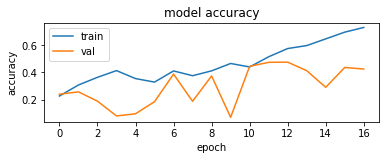

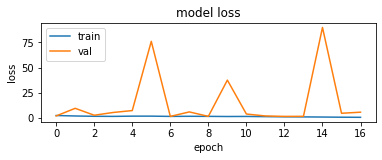

In [29]:
print(history.history.keys())

# summarize history for accuracy
plt.subplot(2, 1, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# summarize history for loss
plt.subplot(2, 1, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# 7. Making predictions

### 7.1 Let's evaluate our model on the test set.

In [30]:
#preds = model_on_gpu.evaluate(X_test, Y_test)
preds = model_on_gpu.evaluate(norm_val_ds)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

91/91 [==============================] - 1s 13ms/step - loss: 5.9258 - accuracy: 0.4253
Loss = 5.925777435302734
Test Accuracy = 0.42531120777130127


### 7.2 Let's try a new, unseen image

Input image shape: (64, 64, 3)


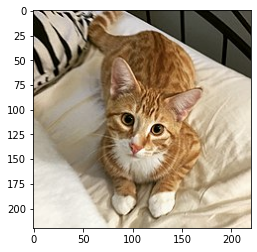

In [31]:
import cv2

test_img_path = '../input/just-one-cat/cat_1.jpg'

img = cv2.imread(test_img_path)
RGB_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

dim = (64, 64)
x = cv2.resize(RGB_img, dim, interpolation = cv2.INTER_AREA)

print('Input image shape:', x.shape)
plt.imshow(RGB_img)

In [32]:
x = np.expand_dims(x, axis=0)
x = x/255.0

preds = model_on_gpu.predict(x)
print("Model's prediction has this format: [p(0), p(1), ... , p(5)] = ")
print(preds)

print("The prediction for this image is: ", class_names[np.argmax(preds)])

Model's prediction has this format: [p(0), p(1), ... , p(5)] = 
[[2.0275573e-01 6.2475433e-03 1.1385617e-02 1.2015703e-02 1.2397403e-02
  9.7397842e-02 3.3232593e-04 1.1383737e-03 7.0176058e-04 6.5562767e-01]]
The prediction for this image is:  scoiattolo


# 8. Overfitting when training our Residual Neural Network

In the previous section, we used Keras Callbacks to stop training at the optimum number of epochs: when the loss for the validation set was no longer improving.  

The stopping happened very early in the training. Why do you think that happened ? Have a look at the images we used from 10 different classes, take a look at our model's structure and try to compute the number of parameters the network has to learn through training. Please leave your comments below regarding what can be the cause of our model not learning anymore after only a a couple of epochs. I believe this discussion is quite beneficial to our learning process.  

Now, what happens if I decide not to stop training at epoch < 10 ? I want to see what I end up with if I keep training for 100 epochs. 

In [33]:
model_on_gpu_40e = ResNet50L(input_size = (64, 64, 3), classes = len(class_names))
model_on_gpu_40e.compile(
    optimizer='adam', # optimizer
    loss='categorical_crossentropy', # loss function to optimize
    metrics=['accuracy'] # metrics to monitor
)

start = time.time()
with tf.device('/gpu:0'):
    history = model_on_gpu_40e.fit(
        norm_train_ds, 
        validation_data=norm_val_ds,
        epochs=40,
        #batch_size=64,
    )
stop = time.time()

print(f'Training for 40 epochs on GPU took: {(stop-start)/60} minutes')

Epoch 1/40
362/362 [==============================] - 21s 45ms/step - loss: 3.0877 - accuracy: 0.1959 - val_loss: 2.1429 - val_accuracy: 0.2417
Epoch 2/40
362/362 [==============================] - 15s 42ms/step - loss: 2.2201 - accuracy: 0.2953 - val_loss: 2.1731 - val_accuracy: 0.3164
Epoch 3/40
362/362 [==============================] - 15s 42ms/step - loss: 1.8660 - accuracy: 0.3847 - val_loss: 22.2294 - val_accuracy: 0.1774
Epoch 4/40
362/362 [==============================] - 15s 42ms/step - loss: 1.7724 - accuracy: 0.4114 - val_loss: 871.6391 - val_accuracy: 0.1030
Epoch 5/40
362/362 [==============================] - 15s 42ms/step - loss: 1.7448 - accuracy: 0.4250 - val_loss: 3.7485 - val_accuracy: 0.2645
Epoch 6/40
362/362 [==============================] - 15s 42ms/step - loss: 1.6358 - accuracy: 0.4643 - val_loss: 2.8710 - val_accuracy: 0.3703
Epoch 7/40
362/362 [==============================] - 15s 42ms/step - loss: 1.4684 - accuracy: 0.5267 - val_loss: 18.2507 - val_accur

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


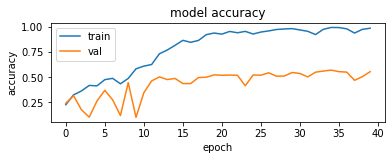

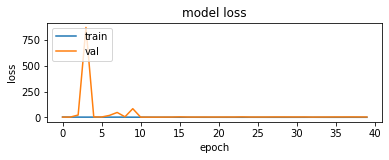

In [34]:
print(history.history.keys())

# summarize history for accuracy
plt.subplot(2, 1, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# summarize history for loss
plt.subplot(2, 1, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# 9. Wrapping up

Here I implemented a 50-layer ResNet using Keras, following the architecture published by <a href="https://openaccess.thecvf.com/content_cvpr_2016/papers/He_Deep_Residual_Learning_CVPR_2016_paper.pdf">He et al. 2016</a> (with slight changes).  

I first tried training on CPU, which was slow. Then I switched on Kaggle's GPU and started training fast.  

I used Kers Callbacks to stop training at the optimum number of epoch, when loss for the validation set was no longer improving. The stopping happened very early in the training when the validation error was still pretty high.  

Then I insisted on training for the whole 40 epochs and noticed no further improvement (no surprise though, I just wanted to see what happens).  

Here's what happened:
- the model has 23,555,082 trainable parameters
- we ask it to learn to classify 10 different classes, after seeing 1446 of each, so 14460 images. 

Usually, compumter vision models are trained on millions of images, training data is also 'augmented' (through various processing techniques like rotations, change in brightness, hue etc), Training from scratch on a handful of data is a nice exercise, but this approach is only to be used as learning experience. The way to go with CNN is to take a pre-trained model, adapt the architecture to the current problem (by replacing the last layer(s)) and fine-tune on the current data. 

The above would explain the low accuracy on training and validation set. The other problem I noticed was the unstable accuracy, jumping up and down abruptly from one epoch to the next. I would experiment with the batch size and/or the learning rate to fix this problem. For example, this was the training setup used in the [He et al Resnet paper from 2016](https://openaccess.thecvf.com/content_cvpr_2016/papers/He_Deep_Residual_Learning_CVPR_2016_paper.pdf)

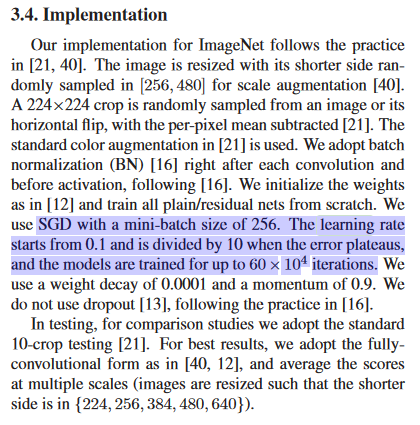

But I will stop here. The goal was to implement the model architecture from scratch using Tensorflow / Keras, not to get a good performance. For good performance I would certainly fine-tune a pre-trained model from the Tensorflow Model Zoo ^^